# HiBench Benchmarks

In [128]:
# Required for everything

# Python settings
from glob import glob
import sys
if not 'spark_log_stats' in sys.path:
    sys.path.append('spark_log_stats')
import pandas as pd
import numpy as np
## Show graph in this notebook instead of opening a window
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from sparklogstats import LogParser

## Make graphs more readable
matplotlib.style.use('ggplot')
matplotlib.rcParams.update({'font.size': 16,
                            'font.family': 'serif',
                            'lines.linewidth': 2})
pd.options.display.max_rows = 9999
pd.options.display.precision = 2

# Functions for all apps
def scale(df):
    df['input'] /= 1024**2  # mebibytes
    for col in df.columns:
        if col == 'seconds' or col.startswith('job'):
            df[col] /= 1000  # seconds
            
def parse_apps(name):
    parser = LogParser()
    apps = []
    for log in sorted(glob('data/hibench/{}/*'.format(name))):
        app = parser.parse_file(log)
        app.slaves = len(app.slaves)
        apps.append(app)
    return apps

In [134]:
df_all = pd.concat([parse_application('sort'), parse_application('kmeans')])
scale(df_all)

## Outliers

In [4]:
# Separate DataFrame for outlier calculation
df_out = pd.DataFrame()
group = df_all.groupby(['application', 'workers', 'input'])
df_out['lower'] = group['seconds'].transform(lambda x: x.quantile(q=.25) - 3*(x.quantile(q=.75)-x.quantile(q=.25)))
df_out['upper'] = group['seconds'].transform(lambda x: x.quantile(q=.75) + 3*(x.quantile(q=.75)-x.quantile(q=.25)))
df_out['outlier'] = (df_all['seconds'] < df_out['lower']) | (df_all['seconds'] > df_out['upper'])

# New column 'outlier'
df_all['outlier'] = df_out['outlier']

# Cleaning
del df_out, group

print('{:d} outliers'.format(df_all['outlier'].sum()))

17 outliers


## Sort Application

In [2]:
# Read Spark log files
def parse_application(name):
    cols = ['application', 'workers', 'input', 'seconds']
    values = {};
    for col in cols:
        values[col] = []
        
    parser = LogParser()
    for log in sorted(glob('data/hibench/{}/*'.format(name))):
        app = parser.parse_file(log)
        values['workers'].append(len(app.slaves))
        values['input'].append(sum(t.metrics.bytes_read for t in app.stages[0].tasks if not t.failed))
        values['seconds'].append(app.duration)
        values['application'].append(app.name)

    return pd.DataFrame(values, columns=cols)

### Outliers

In [5]:
# dfs = DF for ScalaSort
dfs = df_all[df_all['application'] == 'ScalaSort'].drop('application', axis=1)
print('{:d} outliers:'.format(dfs.outlier.sum()))
dfs[dfs.outlier].drop('outlier', axis=1).groupby(['input','workers']).agg(np.size)

12 outliers:


seconds
input    workers         
262.80   1              1
         2              1
525.60   1              2
1051.18  1              2
2102.38  4              2
31327.82 16             1
         64             2
         123            1

### Measurements without outliers

In [6]:
df_clean = dfs[~dfs.outlier].drop('outlier', axis=1).groupby(['input','workers']).agg([np.mean, np.std, np.size])
print("{:g} experiments:".format(df_clean.seconds['size'].sum()))
df_clean

218 experiments:


seconds             
                    mean     std size
input    workers                     
262.80   1         31.24    0.29    9
         2         26.29    0.24    9
525.60   1         49.05    1.41    8
         2         36.14    4.07   10
         4         28.12    1.25   10
1051.18  1         85.56    2.14    8
         2         54.55    2.36   10
         4         71.97   31.20   10
         8         29.82    1.46   10
2102.38  2         93.43    2.30   10
         4         62.00    1.30    8
         8         43.75    1.65   10
3132.80  1        392.65  234.46   10
         2        134.82    3.14   10
         4         88.28    4.21   10
         8         62.75    3.77   10
         12        50.84    2.34   10
         16        47.48    3.92   10
31327.82 16       328.36    8.39    9
         32       280.41   15.84   10
         64       286.15   13.10    8
         123      190.98   16.33    9
         128      174.30   11.50   10

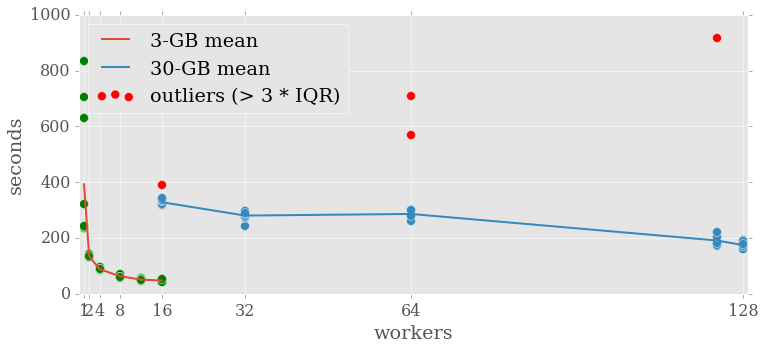

In [7]:
# 3 GB
df_plot = dfs[(dfs.input > 3000) & (dfs.input < 4000)][['workers', 'seconds']]
ax = df_plot.plot.scatter('workers', 'seconds', legend=False, s=80, color='g', figsize=(12, 5))
df_plot.groupby('workers').mean().plot(ax=ax)

# 30 GB
df_plot = dfs[dfs.input > 30000][['workers', 'seconds']]
is_outlier = dfs[dfs.input > 30000]['outlier']
df_plot[~is_outlier].plot.scatter('workers', 'seconds', s=80, legend=False, ax=ax)
df_plot[~is_outlier].groupby('workers').mean().plot(ax=ax)
# Outliers
df_plot[is_outlier].plot.scatter('workers', 'seconds', label='outliers', s=80, ax=ax, color='r', ylim=(0, None))

ax.set_xticks([2**i for i in range(0, 8)])
ax.set_xlim(0, 129)
handles, _ = ax.get_legend_handles_labels()
plt.legend(handles, ['3-GB mean', '30-GB mean', 'outliers (> 3 * IQR)'], loc='upper left')

#plt.savefig('/tmp/img/sort_outliers.pdf')

del df_plot, is_outlier, ax, handles

### Profiling phase

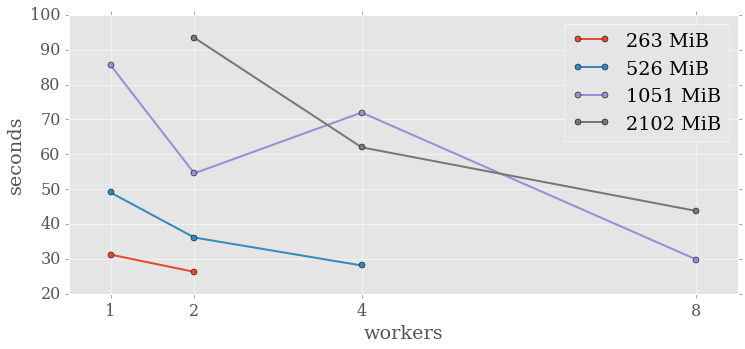

In [8]:
selection = ~dfs.outlier & (dfs.input < 3000)
df_plot = dfs[selection].groupby(['workers', 'input'])['seconds'].mean().unstack()
# Humanizing size labels for legends
df_plot.columns = ['{:d} MiB'.format(int(s + 0.5)) for s in df_plot.columns]
ax = df_plot.plot(figsize=(12, 5), style='-o', xticks=df_plot.index, xlim=(0.5, 8.5))
ax.set_ylabel('seconds')

#plt.savefig('/tmp/img/sort_prof_means.pdf')

del df_plot, selection

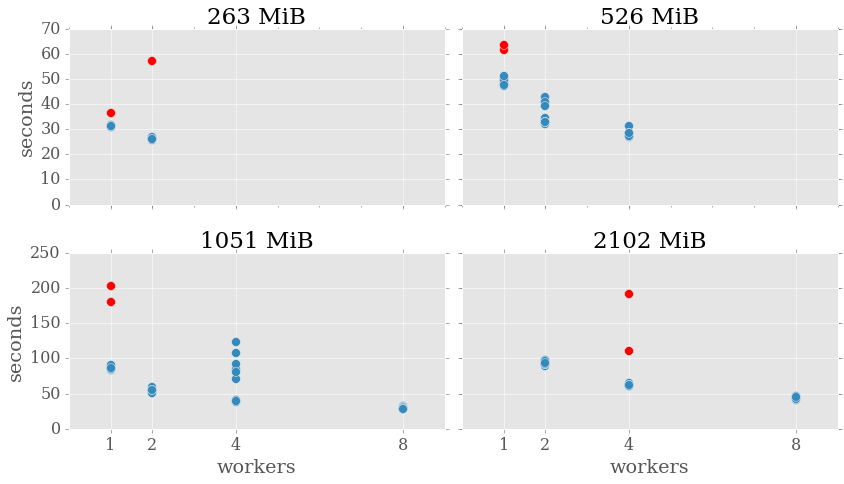

In [9]:
df_plot = dfs[dfs['input'] < 3000]

xticks = sorted(df_plot['workers'].unique())
fig, axes = plt.subplots(2, 2, figsize=(12, 7))
kwargs = {'s': 80, 'sharex': True, 'sharey': True, 'xticks': xticks, 'xlim': (0, xticks[-1] + 1)}

prof_sizes = sorted(df_plot.input.unique())
for size, ymax, x, y in zip(prof_sizes, (70, 70, 250, 250), (0,0,1,1), (0,1,0,1)):
    kwargs['ylim'] = (0, ymax)
    ax = axes[x][y]
    has_size = (df_plot.input == size)
    is_outlier = df_plot.outlier
    df_plot[has_size & ~is_outlier].plot.scatter('workers', 'seconds', ax=ax, **kwargs)
    df_plot[has_size & is_outlier].plot.scatter('workers', 'seconds', ax=ax, color='r', **kwargs)
    ax.set_title('{:d} MiB'.format(int(size + 0.5)))

plt.tight_layout()
#plt.savefig('/tmp/img/sort_prof_outliers.pdf')
    
del df_plot, has_size, is_outlier

### Total Application Time

In [10]:
# Adding features
def add_features(df):
    df['1/workers'] = 1 / df.workers
    for col in ['workers', 'input', 'seconds']:
        df['log_' + col] = np.log2(df[col])

df_feat = dfs[~dfs.outlier].drop('outlier', axis=1)
add_features(df_feat)
df_feat.sample(5, random_state=42)

,workers,input,seconds,1/workers,log_workers,log_input,log_seconds
106,2,525.60,40.24,5.00e-01,1,9.04,5.33
227,128,31327.82,174.07,7.81e-03,7,14.94,7.44
145,4,1051.18,123.11,2.50e-01,2,10.04,6.94
186,16,31327.82,335.40,6.25e-02,4,14.94,8.39
15,2,3132.80,136.00,5.00e-01,1,11.61,7.09


In [11]:
# For each profiling configuration subset (worker numbers, input sizes)
## for each regression model
### for each degree
#### calculate RMSE of the target experiment

import pickle
from itertools import chain, combinations
from sklearn import linear_model, metrics
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

models = [
   linear_model.LinearRegression(fit_intercept=False),
   linear_model.Lasso(),       # ConvergenceWarning
   linear_model.ElasticNet(),  # ConvergenceWarning
   linear_model.RidgeCV()
]
degrees = list(range(1, 6))

# exclude void subset
def powerset(iterable):
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(1, len(s)+1))

def make_regressions():
    regressions = []
    uniq_inputs = df_prof.input.unique()
    for inputs in powerset(uniq_inputs):
        uniq_workers = df_prof[df_prof.input.isin(inputs)].workers.unique()
        for workers in powerset(uniq_workers):
            df_reg = df_prof[df_prof.workers.isin(workers) & df_prof.input.isin(inputs)]
            for reg_model in models:
                for degree in degrees:
                    model = Pipeline([('poly', PolynomialFeatures(degree=degree)), ('linreg', reg_model)])
                    add_regressions(regressions, df_reg, model, degree, workers, inputs)
    return regressions

def add_regressions(regressions, df, model, degree, workers, inputs):
    for use_log in [True, False]:
        rmse = make_regression(df, model, use_log)
        reg = get_regression_info(rmse, model, degree, workers, inputs, use_log)
        regressions.append(reg)
        
def make_regression(df, model, log_scale):
    if log_scale:
        features = ['log_workers', 'log_input']
        time_col = 'log_seconds'
    else:
        features = ['workers', '1/workers', 'input']
        time_col = 'seconds'
    
    model.fit(df[features], df[time_col])
    pred_real = model.predict(df_real[features])
    if log_scale:
        pred_real = np.power(2, pred_real)
        
    return calc_relative_error(df_real.seconds.values, pred_real)

def calc_relative_error(y_true, y_prediction):
    return (np.abs(y_true - y_prediction)/y_true).mean()
    
def calc_rmse(y_true, y_prediction):
    if np.inf in y_prediction:
        return np.inf
    mse = metrics.mean_squared_error(y_true, y_prediction)
    return np.sqrt(mse)

def get_regression_info(rmse, model, degree, workers, inputs, log):
    return {
        'RMSE': rmse,
        'model': str(model.named_steps['linreg'].__class__).split('.')[-1].split("'")[0],
        'degree': degree,
        'workers': workers,
        'inputs': tuple(np.round(inputs).astype(int)),
        'log': log,
        'object': pickle.dumps(model)
    }

df_prof = df_feat[df_feat.input < 3000]
df_real = df_feat[df_feat.input > 3000]

%time regs_sort = make_regressions()

del df_prof, df_real

CPU times: user 24.8 s, sys: 60 ms, total: 24.8 s
Wall time: 24.8 s


/usr/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


In [30]:
df_reg = pd.DataFrame(regs_sort, columns=['log', 'degree', 'RMSE', 'workers', 'inputs', 'model', 'object'])
df_reg = df_reg.sort_values('RMSE').set_index(np.arange(1, len(df_reg) + 1))
print(len(df_reg))
df_reg.drop('object', axis=1)[df_reg.index.isin([1, 2, 3, 4, 5, 99])]

7560


,log,degree,RMSE,workers,inputs,model
1,True,3,0.11,"(2, 4)","(263, 526, 2102)",RidgeCV
2,True,3,0.12,"(2, 4)","(526, 2102)",RidgeCV
3,True,4,0.13,"(2, 4, 8)","(263, 526, 2102)",RidgeCV
4,True,3,0.13,"(1, 8)","(263, 526, 1051, 2102)",RidgeCV
5,True,3,0.13,"(1, 8)","(526, 1051, 2102)",RidgeCV
99,True,1,0.26,"(1, 2)","(263,)",LinearRegression


In [13]:
# Best model
features = ['log_workers', 'log_input']
model = pickle.loads(df_reg.iloc[1].object)
df_plot = df_feat[['workers', 'input', 'seconds']].copy()
df_plot['Model 1'] = np.power(2, model.predict(df_feat[features]))

# Model with rank 99, fewer workers, less input size
model = pickle.loads(df_reg.iloc[99].object)
df_plot['Model 99'] = np.power(2, model.predict(df_feat[features]))

df_plot.sample(5, random_state=42)

,workers,input,seconds,Model 1,Model 99
106,2,525.60,40.24,35.98,39.67
227,128,31327.82,174.07,163.52,112.59
145,4,1051.18,123.11,39.82,47.59
186,16,31327.82,335.40,305.09,266.14
15,2,3132.80,136.00,133.06,132.63


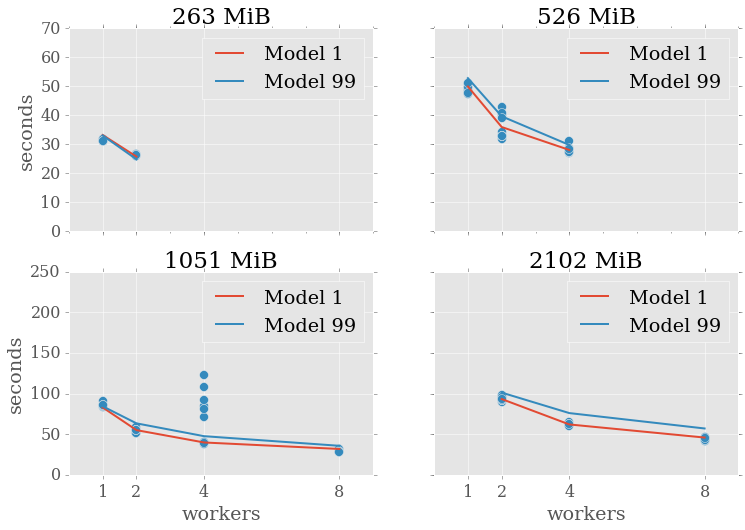

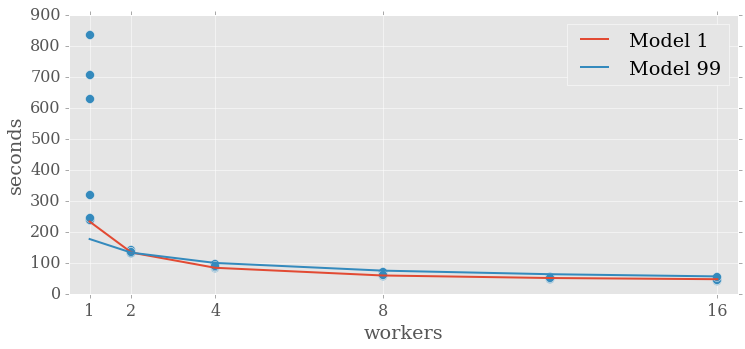

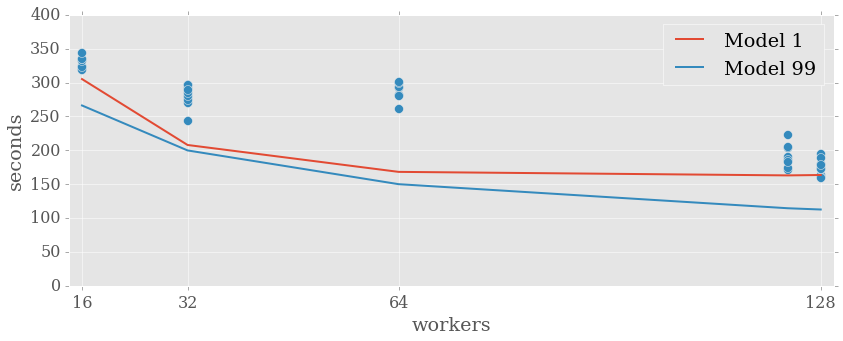

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
kwargs = {'s': 80, 'sharex': True, 'sharey': True, 'xticks': xticks, 'xlim': (0, 9)}

prof_sizes = sorted(df_plot.input.unique())
for size, ymax, x, y in zip(prof_sizes, (70, 70, 250, 250), (0,0,1,1), (0,1,0,1)):
    kwargs['ylim'] = (0, ymax)
    ax = axes[x][y]
    has_size = (df_plot.input == size)
    
    df_mean = df_plot[has_size].groupby(['workers', 'input'], as_index=False).mean()
    df_mean.plot('workers', 'Model 1', ax=ax)
    df_mean.plot('workers', 'Model 99', ax=ax)
    df_plot[has_size].plot.scatter('workers', 'seconds', ax=ax, **kwargs)
    
    ax.set_title('{:d} MiB'.format(int(size + 0.5)))

def plot_two_models(select):
    df_mean = df_plot[select].groupby(['workers', 'input'], as_index=False).mean()
    ax = df_mean.plot('workers', 'Model 1', figsize=(12,5))
    df_mean.plot('workers', 'Model 99', ax=ax)
    df_plot[select].plot.scatter('workers', 'seconds', ax=ax, s=80)
    ax.set_ylim(ymin=0)
    return ax

ax = plot_two_models((df_plot.input > 3000) & (df_plot.input < 4000))
ax.set_xlim(0.5, 16.5)
ax.set_xticks([2**i for i in range(0, 5)])

ax = plot_two_models(df_plot.input > 30000)
ax.set_xlim(14, 130)
ax.set_xticks([2**i for i in range(4, 8)])

plt.tight_layout()

del df_mean, has_size

## K-means Application

In [108]:
# Required for K-means app

# From input size, infer number of samples (in thousands)
def input2samples(df):
    b2s = {}
    k_samples = 32
    for mb in sorted(df.input.unique()):
        b2s[mb] = k_samples
        k_samples *= 2

    df.input = df.input.apply(lambda mb: b2s[mb])

### Outliers

In [144]:
# dfk = DF for K-means clustering
dfk = df_all[df_all.application.str.startswith('DenseKMeans')].drop('application', axis=1)

input2samples(dfk)

print('{:d} outliers:'.format(dfk.outlier.sum()))
dfk[dfk.outlier].drop('outlier', axis=1).groupby(['input','workers']).agg(np.size)

AttributeError: 'DataFrame' object has no attribute 'outlier'

### Measurements without outliers

In [16]:
df_clean = dfk.drop('outlier', axis=1).groupby(['input','workers']).agg([np.mean, np.std, np.size])
print("{:g} experiments:".format(df_clean.seconds['size'].sum()))
df_clean

740 experiments:


seconds             
                  mean     std size
input workers                      
32    1          18.97    1.16   10
      2          18.72    2.28   10
      3          18.45    2.47   10
      4          18.88    0.64   10
      5          19.72    0.88   10
      6          20.97    0.95   10
      7          21.90    2.05   10
      8          26.26    9.66   10
64    1          19.08    0.80   10
      2          18.60    0.56   10
      3          17.92    0.38   10
      4          19.13    0.64   10
      5          20.41    0.76   10
      6          21.32    0.90   10
      7          21.78    1.10   10
      8          22.56    1.06   10
128   1          20.51    0.74   10
      2          19.37    0.54   10
      3          18.60    0.55   10
      4          19.71    0.49   10
      5          21.00    0.48   10
      6          21.29    0.93   10
      7          22.50    0.85   10
      8          22.42    0.60   10
256   1          22.83    0.78   10
      2          21.02    1.01   10
      3          19.50    0.42   10
      4          20.57    0.52   10
      5          21.58    0.82   10
      6          22.76    0.60   10
      7          23.64    0.91   10
      8          24.39    0.83   10
512   1          27.80    0.66   10
      2          24.19    0.61   10
      3          21.51    0.45   10
      4          22.68    0.53   10
      5          23.69    0.85   10
      6          24.85    0.72   10
      7          25.54    1.14   10
      8          25.99    1.50   10
1024  1          36.55    1.22   10
      2          30.13    0.73   10
      3          24.90    0.45   10
      4          26.01    0.55   10
      5          27.45    0.85   10
      6          28.37    0.83   10
      7          28.60    0.81   10
      8          29.76    0.96   10
2048  1          52.56    1.60   10
      2          40.73    2.14   10
      3          30.98    0.66   10
      4          32.07    0.85   10
      5          33.35    0.80   10
      6          34.46    1.27   10
      7          34.50    0.90   10
      8          35.25    1.21   10
4096  1         144.61    2.55   10
      2          55.40    1.58   10
      3          44.18    1.17   10
      4          42.52    2.17   10
      5          38.88    0.85   10
      6          39.74    0.84   10
      7          40.50    0.71   10
      8          42.32    1.20   10
8192  2         870.80   32.39   10
      4         286.28   25.29   10
      8          61.45    2.09   10
      16         60.72   13.48   10
      32         52.55    3.84   10
16384 8        1422.34  347.03   10
      16        419.93   72.47   10
      32         74.69    2.26   10
      64         71.54    4.37   10
      128        76.36   14.36   10

###  Target experiment

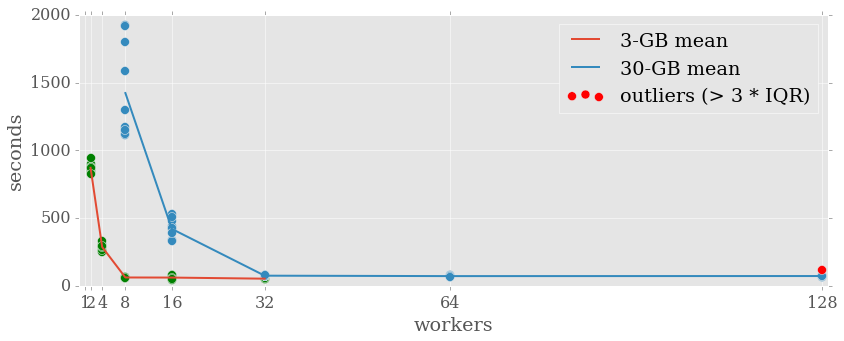

In [26]:
# 8M samples
df_plot = dfk[dfk.input == 8192][['workers', 'seconds']]
ax = df_plot.plot.scatter('workers', 'seconds', legend=False, s=80, color='g', figsize=(12, 5))
df_plot.groupby('workers').mean().plot(ax=ax)

# 16M samples
df_16 = dfk[dfk.input == 16384]
df_plot = df_16[['workers', 'seconds']]
is_outlier = df_16['outlier']
df_plot[~is_outlier].plot.scatter('workers', 'seconds', s=80, legend=False, ax=ax)
df_plot[~is_outlier].groupby('workers').mean().plot(ax=ax)
# Outliers
df_plot[is_outlier].plot.scatter('workers', 'seconds', label='outliers', s=80, ax=ax, color='r', ylim=(0, 2000))

ax.set_xticks([2**i for i in range(0, 8)])
ax.set_xlim(0, 129)
handles, _ = ax.get_legend_handles_labels()
plt.legend(handles, ['3-GB mean', '30-GB mean', 'outliers (> 3 * IQR)'])

plt.tight_layout()
#plt.savefig('/tmp/img/kmeans.pdf')


del df_plot, is_outlier, ax, handles, df_16

### Profiling phase

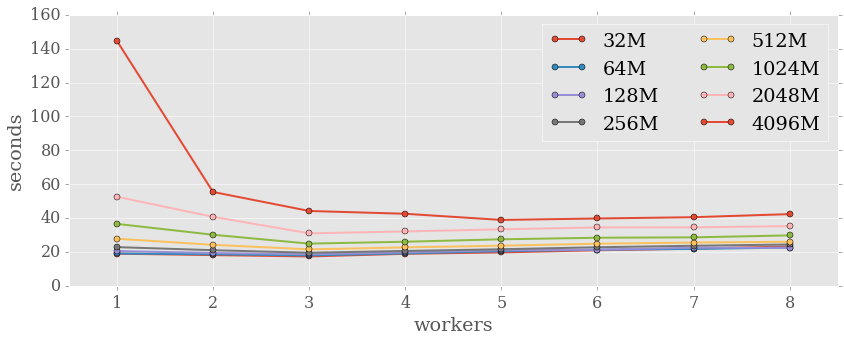

In [27]:
selection = ~dfk.outlier & (dfk.input < 8192)
df_plot = dfk[selection].groupby(['workers', 'input'])['seconds'].mean().unstack()
# Humanizing size labels for legends
cols_bak = df_plot.columns
df_plot.columns = ['{:d}M'.format(int(s + 0.5)) for s in df_plot.columns]
ax = df_plot.plot(figsize=(12, 5), style='-o', xlim=(0.5, 8.5))
ax.set_ylabel('seconds')
plt.legend(ncol=2)

plt.tight_layout()
#plt.savefig('/tmp/img/kmeans_prof_means.pdf')

df_plot.columns = cols_bak
del selection

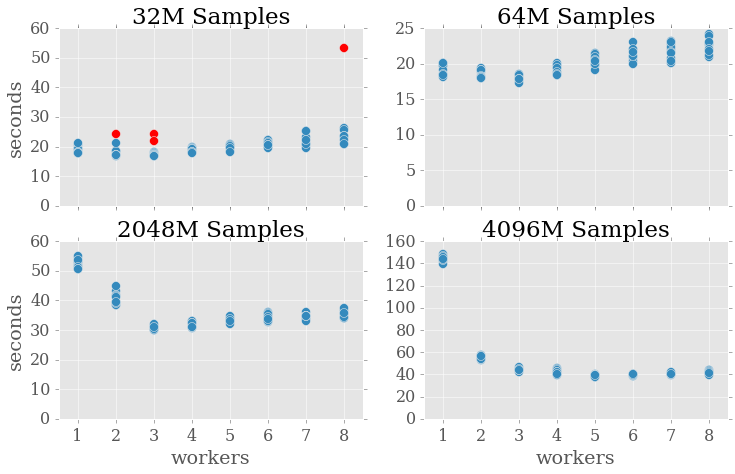

In [19]:
df_plot = dfk[dfk.input < 8192]

xticks = sorted(df_plot['workers'].unique())
fig, axes = plt.subplots(2, 2, figsize=(12, 7))
kwargs = {'s': 80, 'sharex': True, 'sharey': False, 'xticks': xticks, 'xlim': (0, xticks[-1] + 1)}

prof_sizes = (32, 64, 2048, 4096)
for size, x, y in zip(prof_sizes, (0,0,1,1), (0,1,0,1)):
    ax = axes[x][y]
    df_workers = df_plot[df_plot.input == size]
    df_workers[~df_workers.outlier].plot.scatter('workers', 'seconds', ax=ax, **kwargs)
    if not df_workers[df_workers.outlier].empty:
        df_workers[df_workers.outlier].plot.scatter('workers', 'seconds', ax=ax, color='r', **kwargs)
    ax.set_title('{:d}M Samples'.format(size))
    ax.set_xlim(0.5, 8.5)
    ax.set_ylim(ymin=0)
    if y == 1:
        ax.set_ylabel('')
    
del df_workers, ax

In [20]:
# Adding features
df_feat = dfk[~dfk.outlier][['workers', 'input', 'seconds']]
add_features(df_feat)
df_feat.sample(5, random_state=42)

,workers,input,seconds,1/workers,log_workers,log_input,log_seconds
564,4,512,22.38,0.25,2.00,9,4.48
33,1,2048,53.19,1.00,0.00,11,5.73
277,7,4096,39.96,0.14,2.81,12,5.32
200,6,32,22.16,0.17,2.58,5,4.47
194,5,2048,33.52,0.20,2.32,11,5.07


In [21]:
# For each profiling configuration subset (worker numbers, input sizes)
## for each regression model
### for each degree
#### calculate RMSE of the target experiment

models = [
   linear_model.LinearRegression(fit_intercept=False),
   linear_model.Lasso(),       # ConvergenceWarning
   linear_model.ElasticNet(),  # ConvergenceWarning
   linear_model.RidgeCV()
]
degrees = list(range(1, 6))

print(df_feat.size)
reduced = df_feat.input.isin([32, 128, 512, 2048, 4096, 8192, 16384]) & \
          df_feat.workers.isin([1, 2, 4, 8, 16, 32, 64, 128])
df_ffeat = df_feat[reduced]
print(df_ffeat.size)

df_prof = df_ffeat[df_ffeat.input < 8000]
df_real = df_ffeat[df_ffeat.input > 8000]

%time regs_k = make_regressions()

del df_prof, df_real

5145
2079
CPU times: user 1min 1s, sys: 60 ms, total: 1min 1s
Wall time: 1min 2s


/usr/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


In [22]:
df_reg = pd.DataFrame(regs_k, columns=['log', 'degree', 'RMSE', 'workers', 'inputs', 'model', 'object'])
df_reg = df_reg.sort_values('RMSE').set_index(np.arange(1, len(df_reg) + 1))
df_reg.drop('object', axis=1)[:8]

,log,degree,RMSE,workers,inputs,model
1,True,3,0.39,"(1, 2, 8)","(32, 128, 2048)",Lasso
2,True,3,0.39,"(2, 8)","(128, 2048)",ElasticNet
3,True,2,0.39,"(1, 2, 8)","(512, 2048)",ElasticNet
4,True,3,0.39,"(1, 8)","(128, 512, 2048)",ElasticNet
5,True,2,0.39,"(2, 8)","(512, 4096)",ElasticNet
6,True,2,0.39,"(2, 4)","(512, 4096)",ElasticNet
7,True,3,0.40,"(2, 8)","(128, 512, 4096)",Lasso
8,True,1,0.40,"(2, 4, 8)","(2048,)",LinearRegression


In [23]:
# Best model
features = ['log_workers', 'log_input']
model = pickle.loads(df_reg.iloc[1].object)
df_plot = df_feat[['workers', 'input', 'seconds']].copy()
df_plot['Model 1'] = np.power(2, model.predict(df_feat[features]))

# Model with rank 8, fewer workers, less input size
model = pickle.loads(df_reg.iloc[8].object)
df_plot['Model 8'] = np.power(2, model.predict(df_feat[features]))

df_plot.sample(5, random_state=42)

,workers,input,seconds,Model 1,Model 8
564,4,512,22.38,26.26,27.23
33,1,2048,53.19,40.22,41.78
277,7,4096,39.96,46.81,48.62
200,6,32,22.16,18.28,15.96
194,5,2048,33.52,37.46,39.55


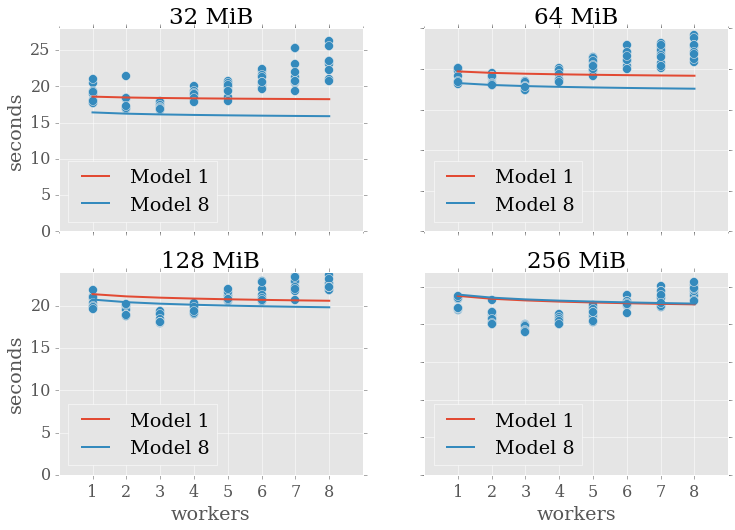

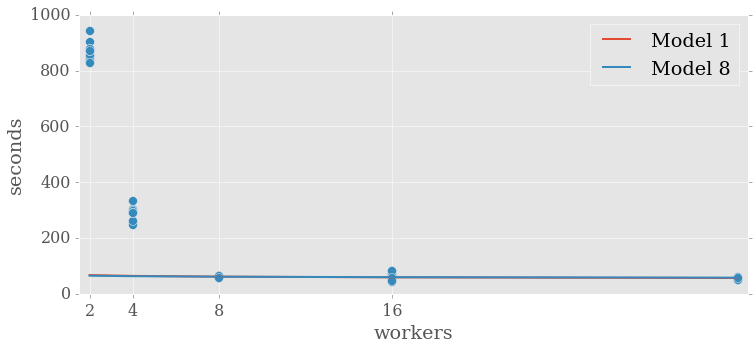

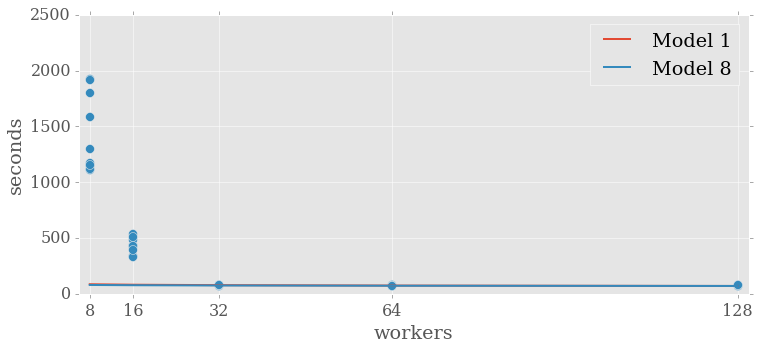

In [24]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
kwargs = {'s': 80, 'sharex': True, 'sharey': True, 'xticks': xticks, 'xlim': (0, 9)}

prof_sizes = sorted(df_plot.input.unique())
for size, ymax, x, y in zip(prof_sizes, (70, 70, 250, 250), (0,0,1,1), (0,1,0,1)):
    kwargs['ylim'] = (0, None)
    ax = axes[x][y]
    has_size = (df_plot.input == size)
    
    df_mean = df_plot[has_size].groupby(['workers', 'input'], as_index=False).mean()
    df_mean.plot('workers', 'Model 1', ax=ax)
    df_mean.plot('workers', 'Model 8', ax=ax)
    df_plot[has_size].plot.scatter('workers', 'seconds', ax=ax, **kwargs)
    
    ax.set_title('{:d} MiB'.format(int(size + 0.5)))

def plot_two_models(select):
    df_mean = df_plot[select].groupby(['workers', 'input'], as_index=False).mean()
    ax = df_mean.plot('workers', 'Model 1', figsize=(12,5))
    df_mean.plot('workers', 'Model 8', ax=ax)
    df_plot[select].plot.scatter('workers', 'seconds', s=80, ax=ax)
    ax.set_ylim(ymin=0)
    return ax

ax = plot_two_models(df_plot.input == 8192)
ax.set_xlim(1.5, 32.5)
ax.set_xticks([2**i for i in range(0, 5)])

ax = plot_two_models(df_plot.input == 16384)
ax.set_xlim(6, 130)
ax.set_xticks([2**i for i in range(3, 8)])


del df_mean, has_size

### Jobs' durations

Replace the total duration by 20 jobs' durations

In [5]:
def get_bytes_read(app):
    tasks = app.stages[0].tasks
    return sum(t.metrics.bytes_read for t in tasks if not t.failed)

def get_jobs_df(apps):
    table = {}
    for app in apps:
        table.setdefault('workers', []).append(app.slaves)
        table.setdefault('input', []).append(get_bytes_read(app))
        for i, job in enumerate(app.jobs):
            col = 'job {:02d}'.format(i)
            table.setdefault(col, []).append(job.duration)
    df = pd.DataFrame(table, columns=sorted(table.keys()))
    scale(df)
    input2samples(df)
    return df

# For each profiling configuration subset (worker numbers, input sizes)
## for each linear regression method
### for each degree
#### build a model

import pickle
from itertools import chain, combinations
from sklearn import linear_model, metrics
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
import pyprind

class Regressor:
    def __init__(self, df, truth_col, features, max_degree, apply_log):
        self.df = df.apply(np.log2) if apply_log else df
        self.truth = truth_col
        self.features = features
        self.degrees = list(range(1, max_degree + 1))
        self.apply_log = apply_log
        self.methods = [
           linear_model.LinearRegression(fit_intercept=False),
#           linear_model.Lasso(),
#           linear_model.ElasticNet(),
#           linear_model.RidgeCV()
        ]

    # exclude void subset
    @staticmethod
    def powerset(iterable):
        s = list(iterable)
        return chain.from_iterable(combinations(s, r) for r in range(1, len(s)+1))
    
    def _init_progress_bar(self):
        n = 0
        df = self.df
        uniq_inputs = df.input.unique()
        for inputs in Regressor.powerset(uniq_inputs):
            uniq_workers = df[df.input.isin(inputs)].workers.unique()
            n += sum(1 for _ in Regressor.powerset(uniq_workers))
        return pyprind.ProgBar(n, monitor=True)
        

    def make_regressions(self):
        bar = self._init_progress_bar()
        regressions = []
        df = self.df
        uniq_inputs = df.input.unique()
        for inputs in Regressor.powerset(uniq_inputs):
            uniq_workers = df[df.input.isin(inputs)].workers.unique()
            for workers in Regressor.powerset(uniq_workers):
                df_reg = df[df.workers.isin(workers) & df.input.isin(inputs)]
                for method in self.methods:
                    for degree in self.degrees:
                        reg = self._add_regression(df_reg, degree, method, workers, inputs)
                        regressions.append(reg)
                bar.update()
        print(bar)
        return regressions
    
        
    def _add_regression(self, df, degree, method, workers, inputs):
        model = self._build_model(df, degree, method)
        return self._get_regression_info(model, degree, workers, inputs)
    
    def _build_model(self, df, degree, method):
        model = Pipeline([('poly', PolynomialFeatures(degree=degree)), ('method', method)])
        model.fit(df[self.features], df[self.truth])
        return model
    
    def _from_log(self, value):
        return np.power(2, value) if self.apply_log else value
        
    def _get_regression_info(self, model, degree, workers, inputs):
        inputs = tuple(np.round(inputs).astype(int))
        return {
            'method': str(model.named_steps['method'].__class__).split('.')[-1].split("'")[0],
            'degree': degree,
            'workers': self._from_log(workers),
            'inputs': self._from_log(inputs),
            'model_pickle': pickle.dumps(model)
        }

    
class RelativeError:
    def __init__(self, df, features, models, truth, is_log):
        self.df = df
        self.features = features
        self.models = models
        self.truth = truth
        self.is_log = is_log
        self.bar = pyprind.ProgBar(self.models.size, monitor=True)
    
    def get_errors(self):
        errors = [self._calc_from_model(m) for m in self.models]
        print(self.bar)
        return errors
            
    def _calc_from_model(self, model_pickle):
        model = pickle.loads(model_pickle)
        predictions = model.predict(features)
        if self.is_log:
            predictions = np.power(2, predictions)
        return self.calc(self.truth, predictions)
    
    def calc(self, y_true, y_prediction):
        self.bar.update()
        return (np.abs(y_true - y_prediction)/y_true).mean()
    
def calc_outliers(df, col, group_by, m):
    group = df.groupby(group_by)
    lower = group[col].transform(lambda x: x.quantile(q=.25) - m*(x.quantile(q=.75)-x.quantile(q=.25)))
    upper = group[col].transform(lambda x: x.quantile(q=.75) + m*(x.quantile(q=.75)-x.quantile(q=.25)))
    return (df[col] > upper) | (df[col] < lower)

In [6]:
# (Slow)
apps = parse_apps('kmeans')

In [7]:
df_jobs = get_jobs_df(apps)
df_jobs.sample(2)

,input,job 00,job 01,job 02,job 03,job 04,job 05,job 06,job 07,job 08,...,job 11,job 12,job 13,job 14,job 15,job 16,job 17,job 18,job 19,workers
226,1024,7.38,0.41,0.26,0.74,0.40,0.88,0.20,0.79,0.28,...,0.75,0.27,3.44,1.96,0.59,1.73,0.45,0.59,0.36,6
221,512,6.95,0.38,0.25,0.61,0.32,0.48,0.27,0.57,0.14,...,0.32,0.14,2.74,1.85,0.34,0.32,0.35,0.33,0.28,6


In [104]:
def plot_jobs_means(input_size, xlim=None):
    group = df_jobs[df_jobs.input == input_size].drop('input', axis=1).groupby('workers')
    jobs = [col for col in df_jobs.columns if col.startswith('job')]
    plt.figure()
    group[jobs].mean().plot(figsize=(12,5), legend=False, style='-o', logx=True, xlim=xlim)
    xs = group.workers.all().index.values
    plt.xticks(xs, xs)
    plt.tight_layout()

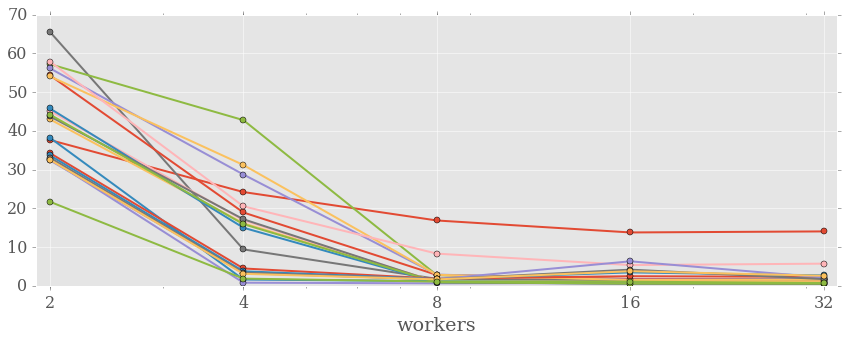

In [105]:
plot_jobs_means(input_size=8192, xlim=(1.9, 33.5))

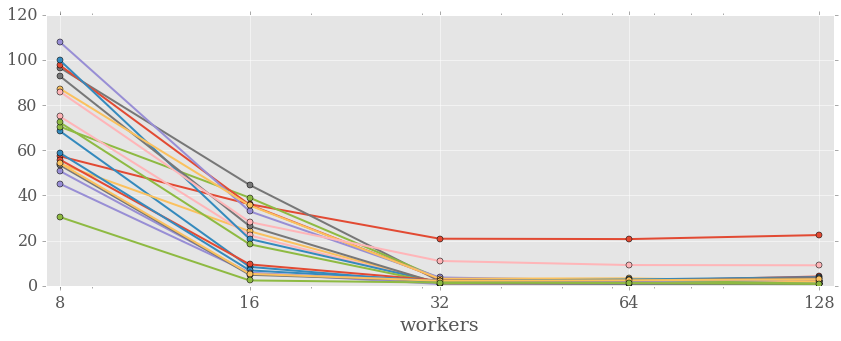

In [106]:
plot_jobs_means(input_size=16384, xlim=(7.6, 135))

In [107]:
def get_task_type(task):
    method = None if not task.metrics else task.metrics.data_read_method
    return (task.locality, method)

In [142]:
# Detecting slow tasks
slow_types = [('ANY', 'Network'), ('ANY', 'Hadoop'), ('PROCESS_LOCAL', 'Hadoop')]
result = {}
for app in apps:
    input_bytes = sum(t.metrics.bytes_read for t in app.stages[0].tasks if not t.failed)
    input_mb = input_bytes / 1024**2
    for job_id, job in enumerate(app.jobs):
        for stage_id, stage in enumerate(job.stages):
            types_found = set(get_task_type(t) for t in stage.tasks)
            if not types_found.isdisjoint(slow_types):
                slow_tasks = sum(get_task_type(t) in slow_types for t in stage.tasks)
                #job_label = 'job {:02d}'.format(job_id)
                result.setdefault('job', []).append(job_id)
                result.setdefault('stage', []).append(stage_id)
                result.setdefault('slow tasks', []).append(slow_tasks)
                result.setdefault('input', []).append(input_mb)
                result.setdefault('workers', []).append(app.slaves)
                result.setdefault('duration', []).append(stage.duration / 1000)
summ = pd.DataFrame(result).groupby(['input', 'job', 'stage'])['slow tasks'].agg([np.min, np.max, np.mean, np.median])
summ[summ.amin != summ.amax]

amin  amax   mean  median
input    job stage                           
3137.82  1   0        14    15  14.60    15.0
         2   0        12    14  12.20    12.0
         3   0         1    15   7.20     7.5
         4   0         1    15   7.50     7.5
         5   0         3    17   9.50     9.5
         6   0         7    17  11.50    10.5
         7   0         2    16   9.55    10.0
         8   0         3    17  10.10    10.0
         9   0         2    17  10.30    11.5
         10  0         3    16  10.00    10.0
         11  0         3    17  10.10    10.5
         12  0         1    17   9.65    10.5
         13  0         1    14   9.60    13.0
         14  0         1    15  11.45    12.0
         15  0        11    13  11.90    11.5
         16  0        11    13  11.80    12.0
         17  0        10    14  11.80    12.0
         18  0        11    13  12.00    12.0
         19  0        11    13  11.80    12.0
12551.30 1   0         1    59  46.31    56.0
         2   0         1    54  37.29    48.0
         3   0         3    60  33.10    39.5
         4   0         4    59  31.90    36.5
         5   0        11    62  38.85    42.0
         6   0        20    66  40.75    41.0
         7   0        12    63  38.40    40.5
         8   0        12    66  38.70    40.0
         9   0        17    62  39.80    41.0
         10  0        15    64  39.70    39.5
         11  0        15    64  39.50    40.5
         12  0        12    61  37.45    38.5
         13  0         1    54  31.76    49.0
         14  0         1    53  33.20    46.0
         15  0         1    52  36.69    47.0
         16  0         3    49  43.36    47.0
         17  0         2    48  42.00    46.0
         18  0         3    48  41.64    45.0
         19  0        42    46  43.80    43.5

### Outliers

In [144]:
outliers = calc_outliers(df_jobs, 'job 00', ['workers', 'input'], 3)
df_jobs[~outliers].groupby(['workers', 'input'])['job 00'].agg(np.size).value_counts()
outliers.sum()

17

In [214]:
# Slow (2min)

df_prof = df_jobs[~outliers & df_jobs.input < 8000]
rows_from = df_prof.shape[0]
reduction = df_prof.input.isin([32, 128, 512, 2048, 4096, 8192, 16384]) & \
            df_prof.workers.isin([1, 2, 4, 8, 16, 32, 64, 128])
df_prof = df_prof[reduction]
rows_to = df_prof.shape[0]
print('Reduced rows from {:d} to {:d}.'.format(rows_from, rows_to))
sys.stdout.flush()

features=['workers', 'input']
truth_col='job 00'
regrr = Regressor(df_prof,
                 truth_col,
                 features,
                 max_degree=5,
                 apply_log=False)
%time regrs = regrr.make_regressions()

Reduced rows from 740 to 300.


0%                          100%
[##############################] | ETA[sec]: 0.000 
Total time elapsed: 137.361 sec


Title: 
  Started: 12/17/2015 20:56:40
  Finished: 12/17/2015 20:58:57
  Total time elapsed: 137.361 sec
  CPU %: 100.000000
  Memory %: 13.441893
CPU times: user 2min 17s, sys: 130 ms, total: 2min 17s
Wall time: 2min 17s


In [215]:
pd_00 = pd.DataFrame(regrs)
pd_00.sample(3)

,degree,inputs,method,model_pickle,workers
19990,1,"(128, 2048, 8192)",LinearRegression,b'\x80\x03csklearn.pipeline\nPipeline\nq\x00)\...,"(2, 32)"
80109,5,"(128, 512, 4096, 8192, 16384)",LinearRegression,b'\x80\x03csklearn.pipeline\nPipeline\nq\x00)\...,"(8, 16, 32, 64, 128)"
13790,1,"(32, 2048, 8192)",LinearRegression,b'\x80\x03csklearn.pipeline\nPipeline\nq\x00)\...,"(1, 8, 16)"


In [221]:
pd_00 = pd.DataFrame(regrs)
df_real = df_jobs[~outliers & (df_jobs.input > 8000)]
features = df_real[features]
truth = df_real[truth_col]
models = pd_00['model_pickle']

rel_error = RelativeError(df_jobs, features, models, truth, is_log=False)
%time pd_00['error'] = rel_error.get_errors()

0%                          100%
[##############################] | ETA[sec]: 0.000 
Total time elapsed: 57.107 sec


Title: 
  Started: 12/17/2015 21:01:22
  Finished: 12/17/2015 21:02:19
  Total time elapsed: 57.107 sec
  CPU %: 100.000000
  Memory %: 13.518197
CPU times: user 57.1 s, sys: 43.3 ms, total: 57.1 s
Wall time: 57.1 s


In [228]:
pd_00[pd_00.workers.apply(lambda x: len(x) < 3) & pd_00.inputs.apply(lambda x: len(x) < 3)].sort_values('error').drop('model_pickle', axis=1).head(30)

,degree,inputs,method,workers,error
2895,1,"(128, 8192)",LinearRegression,"(8, 32)",0.21
7890,1,"(4096, 8192)",LinearRegression,"(8, 32)",0.21
4635,1,"(512, 8192)",LinearRegression,"(8, 32)",0.21
2840,1,"(128, 8192)",LinearRegression,"(1, 8)",0.21
6300,1,"(2048, 8192)",LinearRegression,"(8, 32)",0.21
...,...,...,...,...,...
4580,1,"(512, 8192)",LinearRegression,"(1, 8)",0.29
9518,4,"(8192, 16384)",LinearRegression,"(32, 128)",0.29
6225,1,"(2048, 8192)",LinearRegression,"(16,)",0.30
1005,1,"(32, 8192)",LinearRegression,"(16,)",0.30


### Data locality

In [230]:
def get_info(task):
    method = None if not task.metrics else task.metrics.data_read_method
    return (task.locality, method)

types = set(get_info(t) for a in apps for s in a.stages for t in s.tasks)
types

{('PROCESS_LOCAL', None),
 ('ANY', None),
 ('ANY', 'Network'),
 ('PROCESS_LOCAL', 'Hadoop'),
 ('PROCESS_LOCAL', 'Memory'),
 ('ANY', 'Hadoop')}

In [233]:
types_norms = {}
for a in apps:
    for s in a.stages:
        mean = np.mean([t.duration for t in s.tasks])
        for lm in types:
            lm_tasks = [t.duration for t in s.tasks if lm == get_info(t)]
            if lm_tasks and len(lm_tasks) != len(s.tasks):
                type_norms = types_norms.setdefault(lm, {})
                lm_mean = np.mean(lm_tasks)
                type_norms.setdefault('norm', []).append(lm_mean/mean)
                type_norms.setdefault('workers', []).append(a.slaves)
                
for _t in types_norms:
    print(_t, len(types_norms[_t]['norm']))
    
print('Max workers: %d' % max(max(tn['workers']) for tn in types_norms.values()))

('PROCESS_LOCAL', 'Hadoop') 379
('PROCESS_LOCAL', 'Memory') 691
('ANY', 'Hadoop') 600
('ANY', 'Network') 43
('ANY', None) 2
Max workers: 16


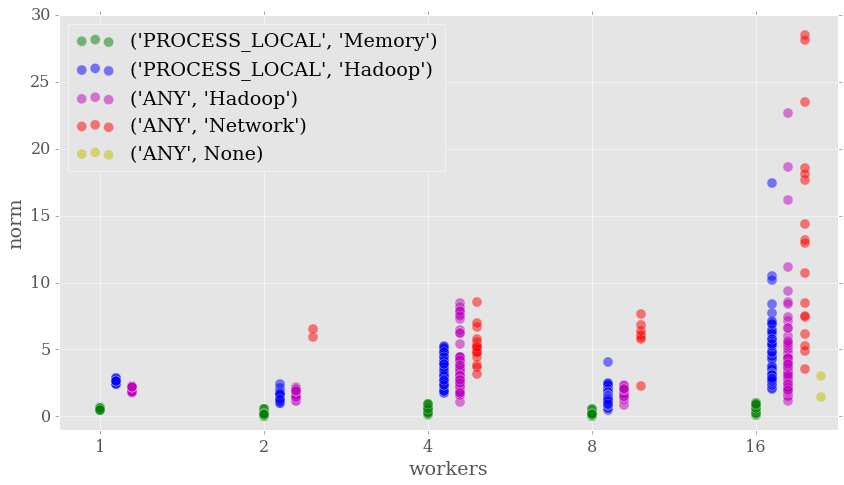

In [132]:
fig, ax = plt.subplots(figsize=(12,7))
ordered_types = [('PROCESS_LOCAL', 'Memory'), ('PROCESS_LOCAL', 'Hadoop'), ('ANY', 'Hadoop'), ('ANY', 'Network'), ('ANY', None)]
hspace = 0
for _t, color in zip(ordered_types, ('g', 'b', 'm', 'r', 'y')):
    _df = pd.DataFrame(types_norms[_t])
    _df['workers'] = np.log2(_df['workers']) + hspace
    hspace += 0.1
    _df.plot.scatter('workers', 'norm', ax=ax, color=color, s=100, alpha=0.5, label=_t)

plt.legend(loc='upper left')
plt.xticks([0, 1, 2, 3, 4], [1, 2, 4, 8, 16])
plt.xlim(-0.25, 4.5)
plt.ylim(-1, 30)
plt.tight_layout()